<a href="https://colab.research.google.com/github/Caduescanti/algoritimo-simplex/blob/main/algoritimo_simplex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#UFC/DEMA, Programacao Linear, 2023.2
# Um implementacao (limitada e ineficiente) do metodo Simplex.

# "Incompleta" porque nao realiza a primeira fase do algoritmo. Em vez disso,
# simplesmente assume que a submatriz formada pelas ultimas m linhas e'
# nao-singular e que a base associada a tal matriz e' viavel (ambas as hipoteses
# nao sao verdadeiras no caso geral).

# "Ineficiente" porque a cada iteracao a submatriz correspondente 'a base atual e'
# explicitamente invertida, o que e' um processo computacionalmente caro. Em vez
# disso, o algoritmo podeeria calcular o proximo dicionario sem explicitamente
# inverter a matriz AB.

# Corrigir estas duas limitacoes do codigo e' sugerido como exercicio.

In [4]:

import numpy as np
import matplotlib.pyplot as plt

TOL = 1e-6 # Constante para comparacoes aproximadas com zero.

# Dados do problema.
# Forma padrao: min <c,x> s.a Ax=b, x>=0.

'''
Formato para o site https://online-optimizer.appspot.com/?model=builtin:default.mod :

var x1 >= 0;
var x2 >= 0;

maximize z:     8*x1 + 4*x2;

subject to c1: 3*x1 +  x2 <= 7;
subject to c2:   x1 +  x2 <= 5;
subject to c3:   x1       <= 2;

end;
'''

c = np.array([ -8, -4, 0, 0, 0])
A = np.array([[ 3, 1, 1, 0, 0],
              [ 1, 1, 0, 1, 0],
              [ 1, 0, 0, 0, 1]])
b = np.array([[7], [5], [2]])
(m,n) = A.shape

print(f"Problema com {m} linhas e {n} colunas.\n")

# ------------------------------------------------------------------------------------------------------
# Base inicial
B = list(range(n-m,n))
N = list(range(n-m))

iteracao = 0

while True:

    iteracao += 1 # Aumentamos o contador de iteracoes. A primeira iteracao e' contada com <iteracao>=1.

    # ------------------------------------------------------------------------------------------------------
    # Particao em torno de variaveis basicas e nao-basicas.
    AB = A[:,B]
    AN = A[:,N]
    cB = c[B]
    cN = c[N]

    # ------------------------------------------------------------------------------------------------------
    # Dados do dicionario
    AB_1 = np.linalg.inv(AB)
    xB = AB_1@b
    AB_1AN = AB_1@AN
    z = cB.T@xB
    cr = cN.T - cB.T@(AB_1AN)
    print(f"B={B}, N={N}, z={z}")
    print(f"Sol.: {xB.T}")

    D = np.block([[xB, -AB_1AN], [z, cr]]) # Parte do dicionario
    print("Dicionario:")
    print(D)

    # ------------------------------------------------------------------------------------------------------
    # Determinar a variavel de entrada
    candidatas = [(N[i], i, custo) for (i,custo) in enumerate(cr) if custo <= -TOL]
    if len(candidatas) == 0:
        print("Solucao otima.")
        break

    # Escolher variavel de indice minimo dentre as variaveis nao-basicas com custo reduzido negativo
    (varEntrada,indiceVarEntrada,crVarEntrada) = min(candidatas)
    print(f"Variavel de entrada: {varEntrada}")

    # ------------------------------------------------------------------------------------------------------
    # Determinar a variavel de saida
    colunaVarEntrada = AB_1AN[:,indiceVarEntrada]
    candidatas = [(xB[i]/pivo, B[i], pivo) for (i,pivo) in enumerate(colunaVarEntrada) if pivo > TOL]
    if len(candidatas) == 0:
        print("Problema ilimitado.")
        break

    # Escolher a variavel de indice minimo dentre aquelas que atingem a razao minima entre o valor da
    # variavel basica e o negativo do valor do pivo. Remeta-se ao conceito de "teste da razao" para
    # perceber como foi escolhida a variavel de saida.
    (razaoMinima,varSaida,_) = min(candidatas)
    print(f"Variavel de saida: {varSaida}")

    # ------------------------------------------------------------------------------------------------------
    # Troca de base
    N = [varSaida if v == varEntrada else v for v in N]
    B = [varEntrada if v == varSaida else v for v in B]

    print("")
   # Pós-processamento para a primeira fase

# Verifica quais variáveis artificiais estão na base com valor zero
variaveis_artificiais_na_base = [var for var in B if var >= n - m and xB[B.index(var)] < TOL]

if len(variaveis_artificiais_na_base) == 0:
    # Não há variáveis artificiais na base, a primeira fase está completa
    print("Primeira fase concluída. Base composta por variáveis originais.")
else:
    print(f"Variáveis artificiais na base com valor zero: {variaveis_artificiais_na_base}")

    for var_artificial in variaveis_artificiais_na_base:
        # Encontre a coluna correspondente à variável artificial na matriz A
        coluna_var_artificial = A[:, var_artificial]

        # Verifique se a coluna contém apenas zeros, exceto um 1 na linha da variável artificial
        if np.all(coluna_var_artificial == 0) and coluna_var_artificial[B.index(var_artificial)] == 1:
            # Encontrou uma variável artificial com valor zero na base
            # Substitua-a por uma variável original

            # Encontre a linha da variável artificial na matriz B
            linha_var_artificial = B.index(var_artificial)

            # Escolha uma variável original para entrar na base
            for var_original in N:
                if np.any(AB_1AN[:, N.index(var_original)] > TOL):
                    # Encontre uma variável original com coeficiente positivo na coluna
                    # da variável artificial que está saindo
                    # Faça a troca na base
                    B[linha_var_artificial] = var_original
                    N[N.index(var_original)] = var_artificial
                    print(f"Substituindo variável artificial {var_artificial} por variável original {var_original} na base.")
                    break

# Imprima a nova base obtida após o pós-processamento
print(f"Nova base: {B}")

Problema com 3 linhas e 5 colunas.

B=[2, 3, 4], N=[0, 1], z=[0.]
Sol.: [[7. 5. 2.]]
Dicionario:
[[ 7. -3. -1.]
 [ 5. -1. -1.]
 [ 2. -1. -0.]
 [ 0. -8. -4.]]
Variavel de entrada: 0
Variavel de saida: 4

B=[2, 3, 0], N=[4, 1], z=[-16.]
Sol.: [[1. 3. 2.]]
Dicionario:
[[  1.   3.  -1.]
 [  3.   1.  -1.]
 [  2.  -1.  -0.]
 [-16.   8.  -4.]]
Variavel de entrada: 1
Variavel de saida: 2

B=[1, 3, 0], N=[4, 2], z=[-20.]
Sol.: [[1. 2. 2.]]
Dicionario:
[[  1.   3.  -1.]
 [  2.  -2.   1.]
 [  2.  -1.  -0.]
 [-20.  -4.   4.]]
Variavel de entrada: 4
Variavel de saida: 3

B=[1, 4, 0], N=[3, 2], z=[-24.]
Sol.: [[4. 1. 1.]]
Dicionario:
[[  4.   -1.5   0.5]
 [  1.   -0.5   0.5]
 [  1.    0.5  -0.5]
 [-24.    2.    2. ]]
Solucao otima.
Primeira fase concluída. Base composta por variáveis originais.
Nova base: [1, 4, 0]


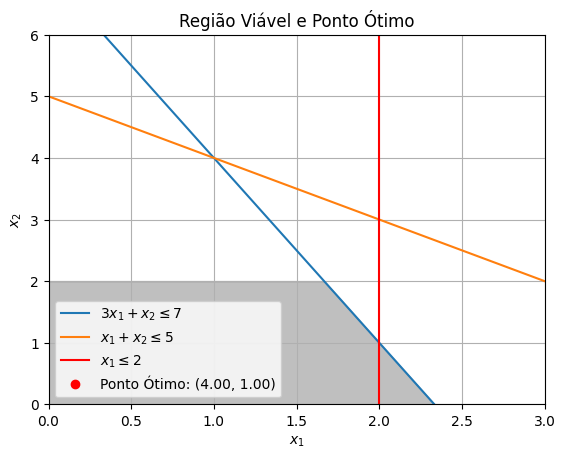

In [6]:
# Plotagem da região viável e do ponto ótimo

# Definindo as restrições
x1 = np.linspace(0, 3, 400)
x2_1 = (7 - 3 * x1)  # 3*x1 + x2 <= 7
x2_2 = (5 - x1)      # x1 + x2 <= 5
x2_3 = np.full_like(x1, 2)  # x1 <= 2

# Plotando as restrições
plt.plot(x1, x2_1, label=r'$3x_1 + x_2 \leq 7$')
plt.plot(x1, x2_2, label=r'$x_1 + x_2 \leq 5$')
plt.axvline(x=2, color='r', label=r'$x_1 \leq 2$')

# Preenchendo a região viável
plt.fill_between(x1, np.minimum.reduce([x2_1, x2_2, x2_3]), 0, where=(x1 >= 0) & (x2_1 >= 0) & (x2_2 >= 0), color='gray', alpha=0.5)

# Extrair os valores de xB corretamente
x1_opt = xB[0][0]  # Primeiro elemento da matriz xB
x2_opt = xB[1][0]  # Segundo elemento da matriz xB

# Plotando o ponto ótimo
plt.plot(x1_opt, x2_opt, 'ro', label=f'Ponto Ótimo: ({x1_opt:.2f}, {x2_opt:.2f})')

# Configurações do gráfico
plt.xlim(0, 3)
plt.ylim(0, 6)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Região Viável e Ponto Ótimo')
plt.legend()
plt.grid(True)
plt.show()